# Continuous optimization

In [1]:
from cont_optim import *

I will be expementing with functions from **BBOB** benchmark (as shown on the practicals). 
Specifically with:
```
f01_sphere,
f02_ellipsoidal,
f06_attractive_sector,
f08_rosenbrock,
f10_rotated_ellipsoidal
```
I will be using the default implementation from co_functions.py in 10 dimensions.

## Let's run the expement with the default settings

In [9]:
exp_id = "default"
run_experiment(exp_id=exp_id, max_gen=100)

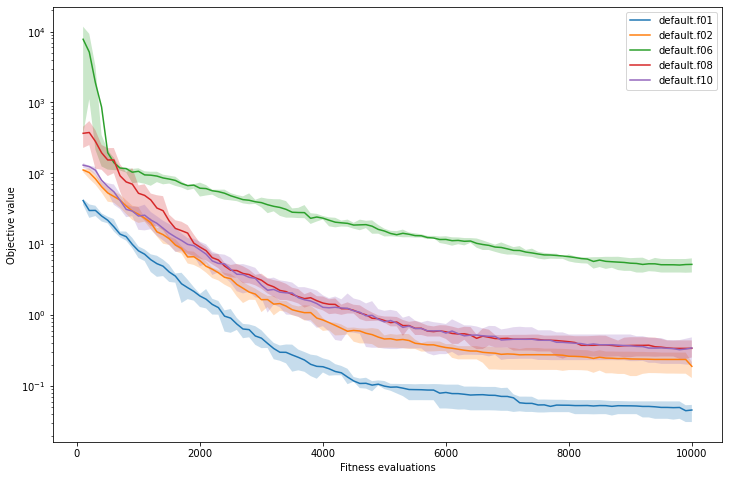

In [10]:
def plot_all(exp_id):
    plt.figure(figsize=(12, 8))
    plt.yscale("log")
    utils.plot_experiments(OUT_DIR, list(map(lambda s: exp_id + "." + s, fit_names)))
    plt.show()
plot_all(exp_id)

## Let's play with the operators
### Mutation with exponential decay
I will decrease the mutation noise std exponentially. The step size can be allowed to be a little bit bigger compared to the default, because it is being decreased so much.

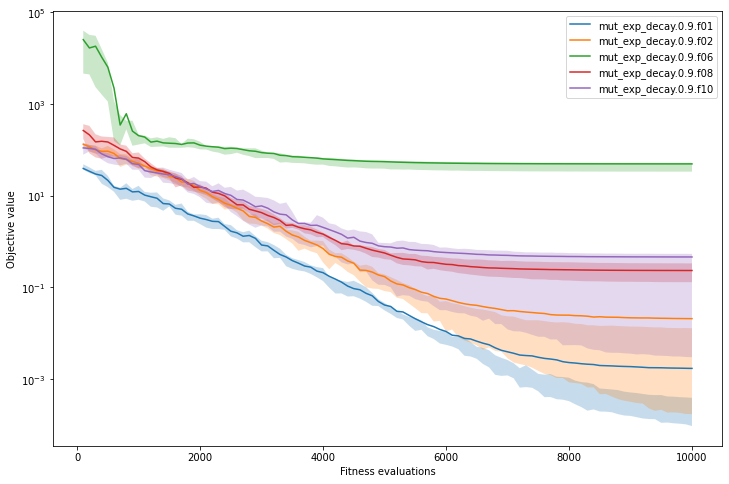

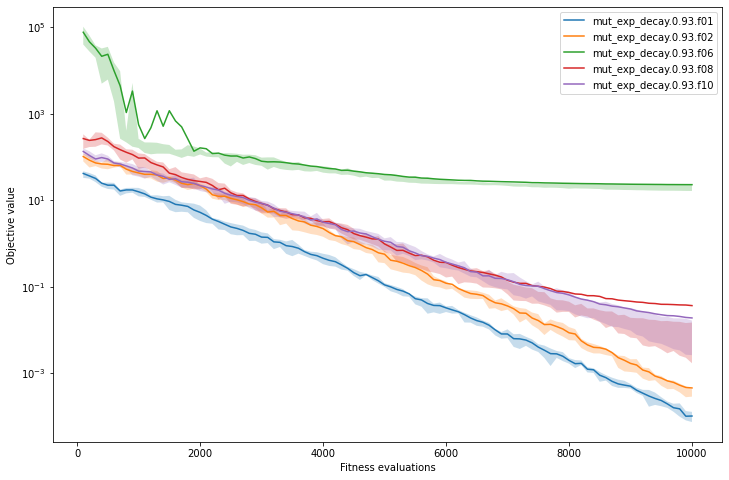

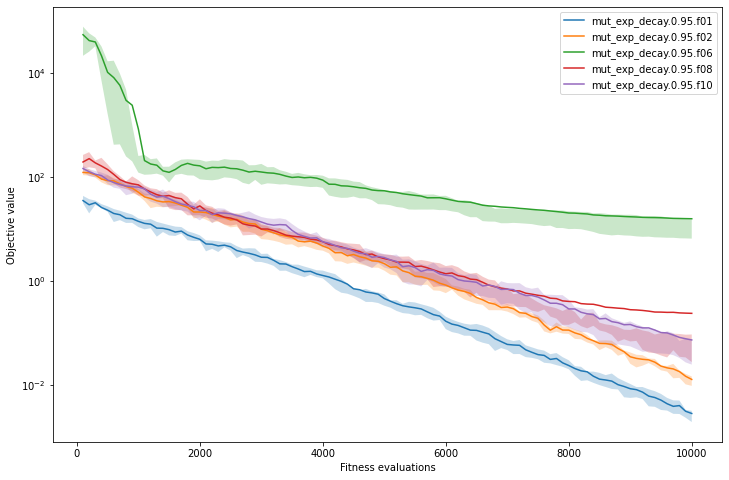

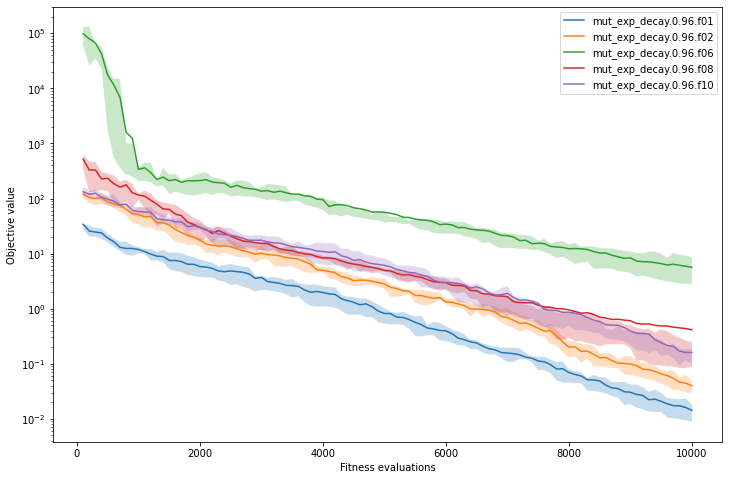

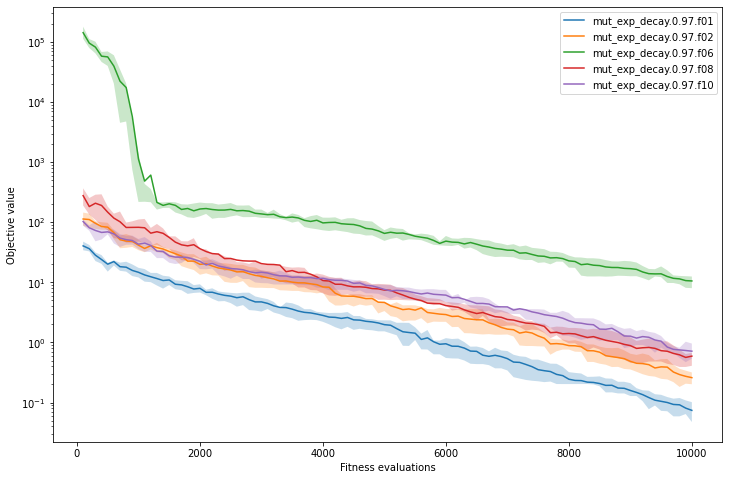

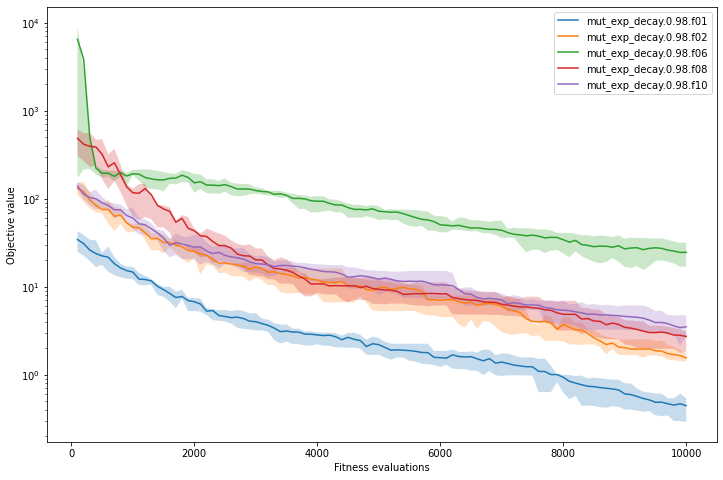

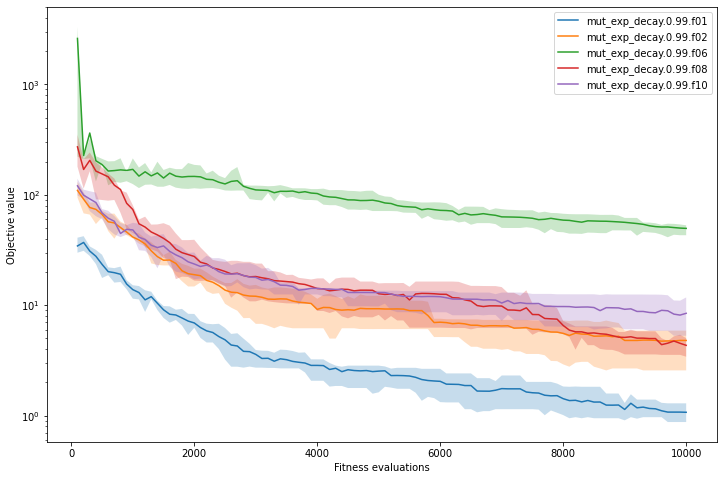

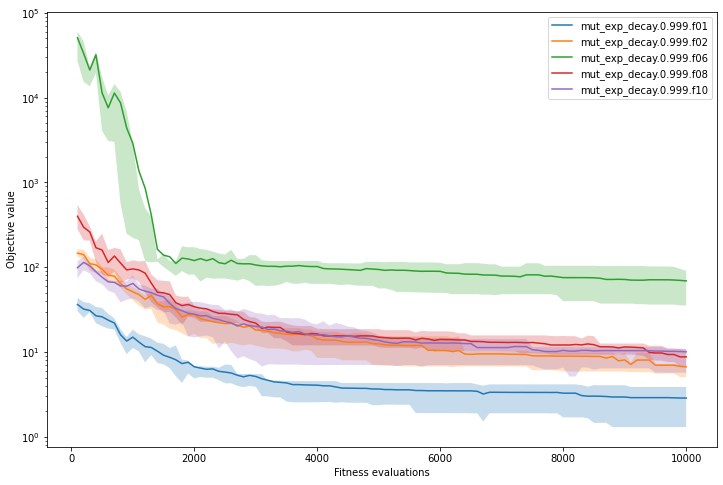

In [4]:
import math
class MutExpDecay(Mutation):

    def __init__(self, step_size, decay_factor):
        self.decay_factor = decay_factor
        self.step_size = step_size

    def __call__(self, ind):
        return ind + self.step_size*np.random.normal(size=ind.shape)*self.decay_factor**pub_vars.current_gen

for decay in (0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999):
    exp_id = f"mut_exp_decay.{decay}"
    mut_op = MutExpDecay(MUT_STEP * 10, decay_factor=decay)
    run_experiment(exp_id=exp_id, mutation_op=mut_op, max_gen=100)
    plot_all(exp_id)


The results are pretty interesting. Large decay of 0.9 makes the mutation step too small too fast and the evolution doesn't have enough time to converge. Decay rate of 0.93 yields the best results, as the step size is in its effective range for substantial part of the evolution. Small decay results in a step size, that doesn't decrease almost at all so the noise in the mutation is too large to find the optimal solution. The disadvantage of this attitude is that the hyperparameters are interdependent, specifically the number of generations influences the optimal decay rate. This could be mitigated by setting exponential decay schedule with fixed starting and ending mutation step-size. Another problem is, that different dimensions may require differrent step sizes.

### What if we turn-off the crossover?

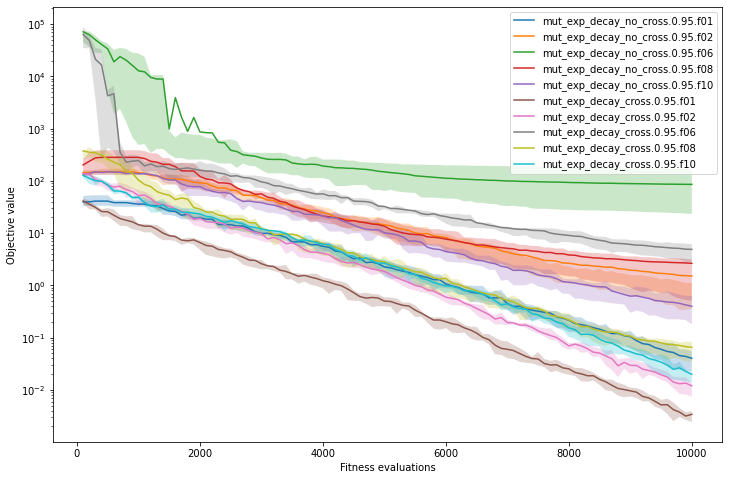

In [5]:
decay = 0.95

# without crossover
exp_id_no_cross = f"mut_exp_decay_no_cross.{decay}"
mut_op = MutExpDecay(MUT_STEP * 10, decay_factor=decay)
run_experiment(exp_id=exp_id_no_cross, mutation_op=mut_op, max_gen=100, cx_prob=0)

# with crossover
exp_id_cross = f"mut_exp_decay_cross.{decay}"
mut_op = MutExpDecay(MUT_STEP * 10, decay_factor=decay)
run_experiment(exp_id=exp_id_cross, mutation_op=mut_op, max_gen=100)

plt.figure(figsize=(12, 8))
plt.yscale("log")
utils.plot_experiments(OUT_DIR, list(map(lambda s: exp_id_no_cross + "." + s, fit_names)))
utils.plot_experiments(OUT_DIR, list(map(lambda s: exp_id_cross + "." + s, fit_names)))
plt.show()


Crossover achives better result for each of the optimized functions

## 1/5 Rule
Let's modify the mutation operator, so that it adaptively increases/decreases its sigma. If on average 1/5 of mutated individuals are better, the sigma stays the same. If less than 1/5 is better, the sigma will exponentially decrease, if more than 1/5 is better, the sigma will exponentially increase. 

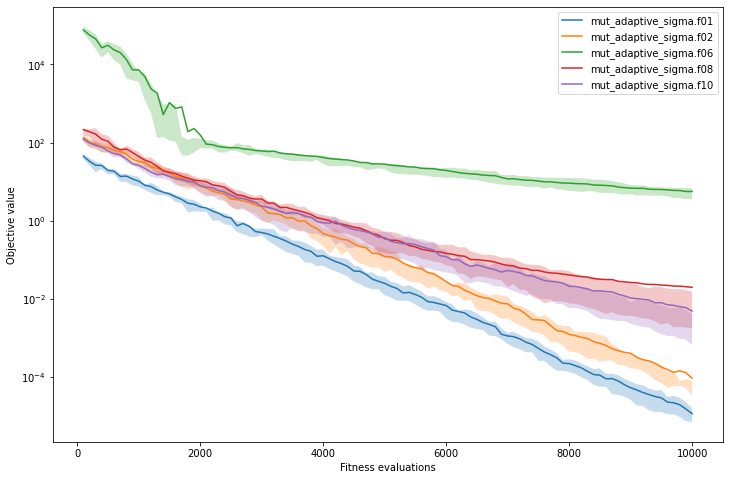

In [6]:
import math
class MutAdaptive(Mutation):

    def __init__(self, init_sigma):
        self.sigma = init_sigma
        

    def __call__(self, ind):
        f1 = pub_vars.fit_func(ind)
        new_ind = ind + self.sigma*np.random.normal(size=ind.shape)
        f2 = pub_vars.fit_func(new_ind)
        self.sigma = self.sigma * math.e**(1/DIMENSION * ((1 if f2 >= f1 else 0) - 0.2))
        return new_ind


exp_id = f"mut_adaptive_sigma"
mut_op = MutAdaptive(1)
run_experiment(exp_id=exp_id, mutation_op=mut_op, max_gen=100)
plot_all(exp_id)


Adaptive sigma achieves best result so far, but we can see, that 100 generations is not enough for the optimization to converge.


Let's increase the number of generations and the population size, so that we can see how far we can push it.

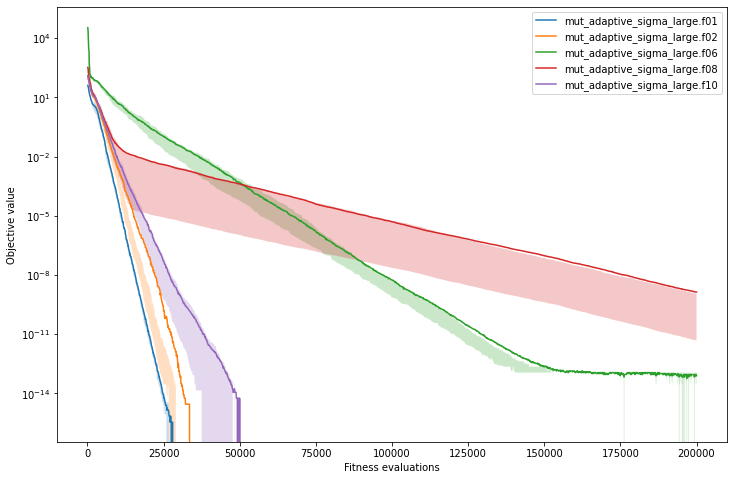

In [8]:
import math
class MutAdaptive(Mutation):

    def __init__(self, init_sigma):
        self.sigma = init_sigma
        

    def __call__(self, ind):
        f1 = pub_vars.fit_func(ind)
        new_ind = ind + self.sigma*np.random.normal(size=ind.shape)
        f2 = pub_vars.fit_func(new_ind)
        self.sigma = self.sigma * math.e**(1/DIMENSION * ((1 if f2 >= f1 else 0) - 0.2))
        return new_ind


exp_id = f"mut_adaptive_sigma_large"
POP_SIZE = 500
mut_op = MutAdaptive(1)
run_experiment(exp_id=exp_id, mutation_op=mut_op, max_gen=2000)
plot_all(exp_id)

We can see that given enough time, the 1/5 adaptive sigma results in stable optimization and it can find optimal solutions without explicit hyperparameter tuning.